# Data Parameters
(Basically, this will be deleted, as we keep iterating on this until we can get the next checkpoint)

Input

- Frames: 5 in 1 out
- Target: 1 station (LA N. Main St.)
- Channels: All

Model
- Variation
```

```

Result
- sdf

General Notes


In [1]:
# file locations
import sys
sys.path.append("/home/mgraca/Workspace/hrrr-smoke-viz") # for libs.plotting
model_checkpoint_file = '/home/mgraca/Workspace/hrrr-smoke-viz/pwwb-experiments/tensorflow/experiment_output/basic_experiments/model.keras'
data_path = "/home/mgraca/Workspace/hrrr-smoke-viz/pwwb-experiments/tensorflow/final_input_data/two_yrs_daily/"

# Data parameters
START_DATE = "2022-12-01-00"
END_DATE = "2024-12-01-00"

# Define bounding box
lat_bottom, lat_top = 33.5, 34.5
lon_bottom, lon_top = -118.75, -117.0
extent = (lon_bottom, lon_top, lat_bottom, lat_top)

# Input data shape
dim = 40
frames_per_sample = 5
EPOCHS = 100
BATCH_SIZE = 32

print(f"{extent}")
print(f"Grid dimension: {dim}x{dim}")
print(f"Frames per sample: {frames_per_sample}")

(-118.75, -117.0, 33.5, 34.5)
Grid dimension: 40x40
Frames per sample: 5


# Data Ingestion and Preprocessing

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import os
from datetime import datetime

#from libs.sequence import PWWBPyDataset

In [3]:

X_test_files =  ["AirNow_PM25_X_test.npy"]
X_train_files = ["AirNow_PM25_X_train.npy"]
X_valid_files = ["AirNow_PM25_X_valid.npy"]
'''
X_test_files =  ["AirNow_PM25_X_test.npy", "HRRR_COLMD_X_test.npy", "MAIAC_AOD_X_test.npy", "METAR_Wind_U_X_test.npy", "METAR_Wind_V_X_test.npy", "TROPOMI_NO2_X_test.npy"]
X_train_files = ["AirNow_PM25_X_train.npy", "HRRR_COLMD_X_train.npy", "MAIAC_AOD_X_train.npy", "METAR_Wind_U_X_train.npy", "METAR_Wind_V_X_train.npy", "TROPOMI_NO2_X_train.npy"]
X_valid_files = ["AirNow_PM25_X_valid.npy", "HRRR_COLMD_X_valid.npy", "MAIAC_AOD_X_valid.npy", "METAR_Wind_U_X_valid.npy", "METAR_Wind_V_X_valid.npy", "TROPOMI_NO2_X_valid.npy"]
'''
Y_test_files = "Y_test.npy"
Y_train_files = "Y_train.npy"
Y_valid_files = "Y_valid.npy"

In [4]:
''' y is not trimmed, can't use this method
BATCH_SIZE = 32
X_training_files_paths = [f"{path + file}" for file in X_train_files]
Y_training_files_paths = f"{path + Y_train_files}"
generator = PWWBPyDataset(X_training_files_paths, Y_training_files_paths, BATCH_SIZE, workers=8, use_multiprocessing=True)

history = seq.fit(
    generator,
    epochs=EPOCHS,
    validation_data=(X_valid_scaled, Y_valid),
    callbacks=callbacks
)
'''
X_train = np.stack([np.load(f"{data_path + file}") for file in X_train_files], axis=-1)
X_test = np.stack([np.load(f"{data_path + file}") for file in X_test_files], axis=-1)
X_valid = np.stack([np.load(f"{data_path + file}") for file in X_valid_files], axis=-1)

Y_train = np.load(f"{data_path + Y_train_files}")
Y_test = np.load(f"{data_path + Y_test_files}")
Y_valid = np.load(f"{data_path + Y_valid_files}")

In [5]:
# 5 frames in, one frame and one station out
# next frame = 0 (:1)
# LA station = 4
Y_train = Y_train[:, :1, [4]].copy()
Y_test = Y_test[:, :1, [4]].copy()
Y_valid = Y_valid[:, :1, [4]].copy()

# Model Definition

## Architecture

In [6]:
output_frames, output_stations = Y_train.shape[1:]
input_shape = X_train.shape[1:] # (frames, height, width, channels)

print(
    f"X_train shape: {X_train.shape}\n"
    f"Y_train shape: {Y_train.shape}\n\n"
    
    f"X_test shape:  {X_test.shape}\n"
    f"Y_test shape:  {Y_test.shape}\n\n"

    f"X_valid shape: {X_valid.shape}\n"
    f"Y_valid shape: {Y_valid.shape}\n\n"

    f"Input shape:   {input_shape}\n"
    f"Output shape:  ({output_frames}, {output_stations})\n"
)

X_train shape: (508, 5, 40, 40, 1)
Y_train shape: (508, 1, 1)

X_test shape:  (110, 5, 40, 40, 1)
Y_test shape:  (110, 1, 1)

X_valid shape: (109, 5, 40, 40, 1)
Y_valid shape: (109, 1, 1)

Input shape:   (5, 40, 40, 1)
Output shape:  (1, 1)



In [7]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import Conv3D
from keras.layers import ConvLSTM2D
from keras.layers import BatchNormalization, LayerNormalization
from keras.layers import Convolution2D, MaxPooling3D, Flatten, Reshape, GlobalAveragePooling2D
from keras.layers import TimeDistributed, Reshape
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import InputLayer

tf.keras.backend.set_image_data_format('channels_last')

seq = Sequential()

seq.add(
    InputLayer(shape=input_shape)
)

seq.add(
    ConvLSTM2D(
        filters=3, 
        kernel_size=(3, 3),
        padding='same', 
        return_sequences=True,
        #dropout=0.5,
        #recurrent_dropout=0.5,
        #kernel_regularizer=keras.regularizers.l2(0.01)
    )
)

seq.add(
    ConvLSTM2D(
        filters=6, 
        kernel_size=(3, 3),
        padding='same', 
        return_sequences=True,
        #dropout=0.5,
        #recurrent_dropout=0.5,
        #kernel_regularizer=keras.regularizers.l2(0.01)
    )
)

seq.add(
    Conv3D(
        filters=3, 
        kernel_size=(3, 3, 3),
        activation='relu',
        padding='same',
        #kernel_regularizer=keras.regularizers.l2(0.1)
    )
)

seq.add(
    Conv3D(
        filters=1, 
        kernel_size=(3, 3, 3),
        activation='relu',
        padding='same',
        #kernel_regularizer=keras.regularizers.l2(0.1)
    )
)

seq.add(MaxPooling3D((1, 2, 2)))

seq.add(Flatten())

seq.add(Dense(output_stations * output_frames, activation='relu'))

seq.add(Reshape((output_frames, output_stations)))

seq.compile(
    loss='mean_absolute_error', 
    optimizer=keras.optimizers.AdamW(learning_rate=0.001, weight_decay=0.004)
)
seq.summary()

2025-07-11 13:24:45.629726: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-11 13:24:45.637773: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752265485.648630   86341 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752265485.652174   86341 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-11 13:24:45.662714: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 5, 40, 40, 3)   │           444 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 5, 40, 40, 6)   │         1,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 5, 40, 40, 3)   │           489 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 5, 40, 40, 1)   │            82 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 5, 20, 20, 1)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         2,001 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1, 1)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,984 (19.47 KB)

 Trainable params: 4,984 (19.47 KB)

 Non-trainable params: 0 (0.00 B)

## Callbacks

In [8]:
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint, ReduceLROnPlateau
import os
import time

# tensorboard gradient logging callback
# at the end of an epoch, pass in a sample batch and calculate the gradients
class GradientLogger(tf.keras.callbacks.Callback):
    def __init__(self, log_dir, data_sample):
        super().__init__()
        self.writer = tf.summary.create_file_writer(log_dir)
        self.data_sample = data_sample  # A batch of (x, y) from your training data

    def on_epoch_end(self, epoch, logs=None):
        # log gradients
        x, y = self.data_sample

        with tf.GradientTape() as tape:
            loss = self.model.compute_loss(
                y=y, 
                y_pred=self.model(x, training=True)
            )

        gradients = tape.gradient(loss, self.model.trainable_weights)
        grad_norm = tf.linalg.global_norm(gradients)

        # plot gradients
        with self.writer.as_default():
            tf.summary.scalar("gradient_norm/global", grad_norm, step=epoch)
            
            for weight, grad in zip(self.model.trainable_weights, gradients):
                if grad is not None:
                    tf.summary.histogram(f"gradients/{weight.name}", grad, step=epoch)
            self.writer.flush()

# tensorboard callback setup
def get_run_logdir(
    root_logdir, 
    run_id=time.strftime("run_%Y_%m_%d-%H_%M_%S")
):
    return os.path.join(root_logdir, run_id)
    
run_logdir = get_run_logdir(
    root_logdir=os.path.join(os.curdir, "my_logs"),
    run_id="default"
)
tensorboard_callback = TensorBoard(run_logdir, histogram_freq=1)
#gradient_logging_callback = GradientLogger(run_logdir, data_sample=(X_test_scaled[:32], Y_test[:32]))

# model checkpoint callback setup
model_checkpoint_callback = ModelCheckpoint(
    filepath=model_checkpoint_file,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

# lr scheduling callback setup
lr_scheduling_callback = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=10,
)

# early stopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss', 
    patience=20,
    restore_best_weights=True,
)

# define list of callbacks we're gonna use
callbacks = [
    #early_stopping_callback,
    model_checkpoint_callback,
    #lr_scheduling_callback,
    #tensorboard_callback,
    #gradient_logging_callback
]

## Training

In [9]:
history = seq.fit(
    x=X_train,
    y=Y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_valid, Y_valid),
    callbacks=callbacks
)

Epoch 1/100


I0000 00:00:1752265489.462504   86413 service.cc:148] XLA service 0x61d5dfdc4240 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752265489.462522   86413 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2025-07-11 13:24:49.514279: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1752265489.779096   86413 cuda_dnn.cc:529] Loaded cuDNN version 90800
2025-07-11 13:24:50.181129: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[32,6,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,40,40]{3,2,1,0}, f32[6,3,3,3]{3,2,1,0}, f32[6]{0}, f32[32,6,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_conf

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 10.4189

I0000 00:00:1752265491.806773   86413 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 10.3263

2025-07-11 13:24:52.551312: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[28,6,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[28,3,40,40]{3,2,1,0}, f32[6,3,3,3]{3,2,1,0}, f32[6]{0}, f32[28,6,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":1},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-07-11 13:24:52.642654: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[28,3,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[28,1,40,40]{3,2,1,0}, f32[3,1,3,3]{3,2,1,0}, f32[3]{0}, f32[28,3,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, cus

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 10.2364

2025-07-11 13:24:54.931352: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[13,3,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[13,1,40,40]{3,2,1,0}, f32[3,1,3,3]{3,2,1,0}, f32[3]{0}, f32[13,3,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":1},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-07-11 13:24:54.996102: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[13,6,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[13,3,40,40]{3,2,1,0}, f32[6,3,3,3]{3,2,1,0}, f32[6]{0}, f32[13,6,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, cus

16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 237ms/step - loss: 10.2085 - val_loss: 14.6892
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 5.5617 - val_loss: 10.3462
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.3163 - val_loss: 9.9155
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.0664 - val_loss: 9.9483
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 3.8813 - val_loss: 9.6131
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.1016 - val_loss: 9.7709
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 3.9806 - val_loss: 9.3084
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 3.9077 - val_loss: 9.3792
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 3.8982 - val_loss: 9.8027
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.0678 - val_loss: 9.5075
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.0386 - val_loss: 9.5246
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss:

# Model Evaluation


Evaluating model


2025-07-11 13:25:25.567446: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[14,3,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[14,1,40,40]{3,2,1,0}, f32[3,1,3,3]{3,2,1,0}, f32[3]{0}, f32[14,3,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":1},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-07-11 13:25:25.630517: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[14,6,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[14,3,40,40]{3,2,1,0}, f32[6,3,3,3]{3,2,1,0}, f32[6]{0}, f32[14,6,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, cus

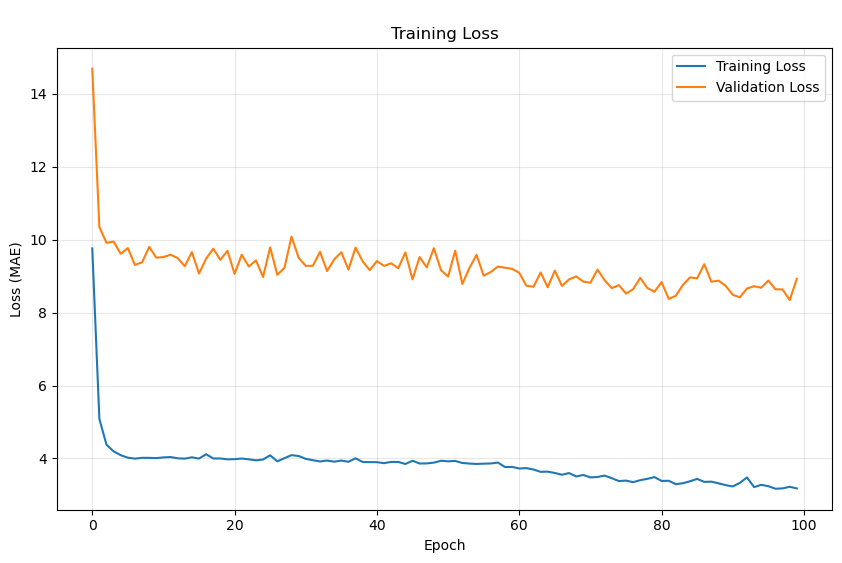

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import datetime

# Evaluate model
print(f"\nEvaluating model")
#model = keras.saving.load_model(model_checkpoint_file)
y_pred = seq.predict(X_test, verbose=0)

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title(f'\nTraining Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.grid(True, alpha=0.3)
plt.show()

In [11]:
from libs.plotting import *
import pandas as pd

results = [
    [
        rmse(Y_test[1:], Y_test[:-1]), 
        rmse(y_pred, Y_test),
        rmse(y_pred[1:], Y_test[:-1]),
    ],
    [
        nrmse(Y_test[1:], Y_test[:-1]),
        nrmse(y_pred, Y_test),        
        nrmse(y_pred[1:], Y_test[:-1]),

    ],
    [        
        mae(Y_test[1:], Y_test[:-1]),
        mae(y_pred, Y_test),
        mae(y_pred[1:], Y_test[:-1]),
    ],
    [
        r2_score(Y_test[:-1], Y_test[1:]),
        r2_score(Y_test, y_pred),
        r2_score(Y_test[:-1], y_pred[1:]),
    ]
]

df = pd.DataFrame(
    results, 
    columns=['Baseline Error', 'Model Error', 'Model Error Shifted'], 
    index=['RMSE', 'NRMSE', 'MAE', 'R2']
)
display(df)

,Baseline Error,Model Error,Model Error Shifted
RMSE,1.466663,4.857516,4.886947
NRMSE,14.367420,47.712005,47.872493
MAE,1.208257,3.995310,4.038663
R2,0.863402,-0.504228,-0.516552


In [12]:
# first-frame error
results = [
    [
        rmse(Y_test[1:, 0], Y_test[:-1, 0]), 
        rmse(y_pred[:, 0], Y_test[:, 0]),
        rmse(y_pred[1:, 0], Y_test[:-1, 0]),
    ],
    [
        nrmse(Y_test[1:, 0], Y_test[:-1, 0]),
        nrmse(y_pred[:, 0], Y_test[:, 0]),        
        nrmse(y_pred[1:, 0], Y_test[:-1, 0]),

    ],
    [        
        mae(Y_test[1:, 0], Y_test[:-1, 0]),
        mae(y_pred[:, 0], Y_test[:, 0]),
        mae(y_pred[1:, 0], Y_test[:-1, 0]),
    ],
    [
        r2_score(Y_test[:-1, 0], Y_test[1:, 0]),
        r2_score(Y_test[:, 0], y_pred[:, 0]),
        r2_score(Y_test[:-1, 0], y_pred[1:, 0]),
    ]
]

df = pd.DataFrame(
    results, 
    columns=['Baseline Error', 'Model Error', 'Model Error Shifted'], 
    index=['RMSE', 'NRMSE', 'MAE', 'R2']
)
display(df)

,Baseline Error,Model Error,Model Error Shifted
RMSE,1.466663,4.857516,4.886947
NRMSE,14.367420,47.712005,47.872493
MAE,1.208257,3.995310,4.038663
R2,0.863402,-0.504228,-0.516552


In [13]:
# clean up dead sensors; more accurate, also allows us to use mape
from sklearn.metrics import mean_absolute_percentage_error as mape
#mape_err = mape(np.squeeze(cleaned_test), np.squeeze(cleaned_pred))

dead_sens = np.where(Y_test == 0)
print(f"{len(dead_sens[0])} samples containing dead sensors removed")

cleaned_test = np.delete(Y_test, dead_sens, 0)
cleaned_pred = np.delete(y_pred, dead_sens, 0)

results = [
    [
        rmse(cleaned_test[1:], cleaned_test[:-1]), 
        rmse(cleaned_pred, cleaned_test),
        rmse(cleaned_pred[1:], cleaned_test[:-1]),
    ],
    [
        nrmse(cleaned_test[1:], cleaned_test[:-1]),
        nrmse(cleaned_pred, cleaned_test),        
        nrmse(cleaned_pred[1:], cleaned_test[:-1]),

    ],
    [        
        mae(cleaned_test[1:], cleaned_test[:-1]),
        mae(cleaned_pred, cleaned_test),
        mae(cleaned_pred[1:], cleaned_test[:-1]),
    ],
    [
        mape(np.squeeze(cleaned_test[:-1]), np.squeeze(cleaned_test[1:]))*100,
        mape(np.squeeze(cleaned_test), np.squeeze(cleaned_pred))*100,
        mape(np.squeeze(cleaned_test[:-1]), np.squeeze(cleaned_pred[1:]))*100,
    ],
    [
        r2_score(cleaned_test[:-1], cleaned_test[1:]),
        r2_score(cleaned_test, cleaned_pred),
        r2_score(cleaned_test[:-1], cleaned_pred[1:]),
    ]
]

df = pd.DataFrame(
    results, 
    columns=['Baseline Error', 'Model Error', 'Model Error Shifted'], 
    index=['RMSE', 'NRMSE', 'MAE', 'MAPE', 'R2']
)
display(df)

0 samples containing dead sensors removed


,Baseline Error,Model Error,Model Error Shifted
RMSE,1.466663,4.857516,4.886947
NRMSE,14.367420,47.712005,47.872493
MAE,1.208257,3.995310,4.038663
MAPE,13.875732,51.314703,52.888625
R2,0.863402,-0.504228,-0.516552


In [14]:
# first frame results
results = [
    [
        rmse(cleaned_test[1:, 0], cleaned_test[:-1, 0]), 
        rmse(cleaned_pred[:, 0], cleaned_test[:, 0]),
        rmse(cleaned_pred[1:, 0], cleaned_test[:-1, 0]),
    ],
    [
        nrmse(cleaned_test[1:, 0], cleaned_test[:-1, 0]),
        nrmse(cleaned_pred[:, 0], cleaned_test[:, 0]),        
        nrmse(cleaned_pred[1:, 0], cleaned_test[:-1, 0]),

    ],
    [        
        mae(cleaned_test[1:, 0], cleaned_test[:-1, 0]),
        mae(cleaned_pred[:, 0], cleaned_test[:, 0]),
        mae(cleaned_pred[1:, 0], cleaned_test[:-1, 0]),
    ],
    [
        mape(np.squeeze(cleaned_test[:-1, 0]), np.squeeze(cleaned_test[1:, 0]))*100,
        mape(np.squeeze(cleaned_test[:, 0]), np.squeeze(cleaned_pred[:, 0]))*100,
        mape(np.squeeze(cleaned_test[:-1, 0]), np.squeeze(cleaned_pred[1:, 0]))*100,
    ],
    [
        r2_score(cleaned_test[:-1, 0], cleaned_test[1:, 0]),
        r2_score(cleaned_test[:, 0], cleaned_pred[:, 0]),
        r2_score(cleaned_test[:-1, 0], cleaned_pred[1:, 0]),
    ]
]

df = pd.DataFrame(
    results, 
    columns=['Baseline Error', 'Model Error', 'Model Error Shifted'], 
    index=['RMSE', 'NRMSE', 'MAE', 'MAPE', 'R2']
)
display(df)

,Baseline Error,Model Error,Model Error Shifted
RMSE,1.466663,4.857516,4.886947
NRMSE,14.367420,47.712005,47.872493
MAE,1.208257,3.995310,4.038663
MAPE,13.875732,51.314703,52.888625
R2,0.863402,-0.504228,-0.516552


📊 TEMPORAL DEGRADATION ANALYSIS
This measures how ConvLSTM prediction accuracy degrades as we predict further into the future.
Later time steps are inherently harder to predict due to error accumulation.



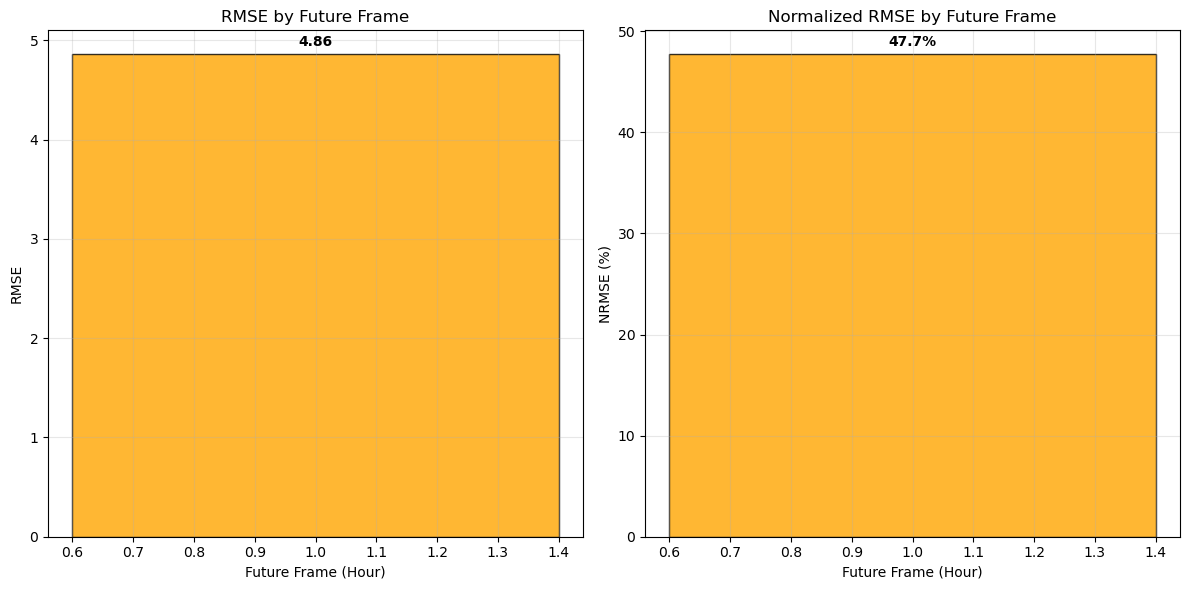


📊 FRAME-BY-FRAME RMSE SUMMARY:
Hour 1: RMSE = 4.858 (47.7%)
📋 DETAILED CONVLSTM PERFORMANCE BREAKDOWN
This section provides comprehensive metrics for each prediction horizon and monitoring station.
Essential for identifying specific model weaknesses and guiding improvements.

📋 DETAILED FRAME-BY-FRAME STATISTICS

🕐 HOUR 1 ANALYSIS
────────────────────────────────────────────────────────────────────────────────────────────────────
┌─ OVERALL PERFORMANCE ──────────────────────────────────────────────────────────┐
│ RMSE:  4.858 (47.7%)   │   MAE:  3.995   │   R²: -0.504              │
└────────────────────────────────────────────────────────────────────────────────┘

📍 BY SENSOR LOCATION:
────────────────────────────────────────────────────────────────────────────────────────────────────
Location                 │RMSE   │%     │MAE    │R²     │Actual │Pred  
─────────────────────────┼───────┼──────┼───────┼───────┼───────┼──────
Los Angeles - N. Main St │4.86   │47.7  %│4.00   │-0.504 │

In [15]:
sensor_names = ['Los Angeles - N. Main Street']
plot_frame_by_frame_rmse(y_pred, Y_test)
print_detailed_frame_stats(y_pred, Y_test, sensor_names)

# Plots

## Snapshot plots - first frame

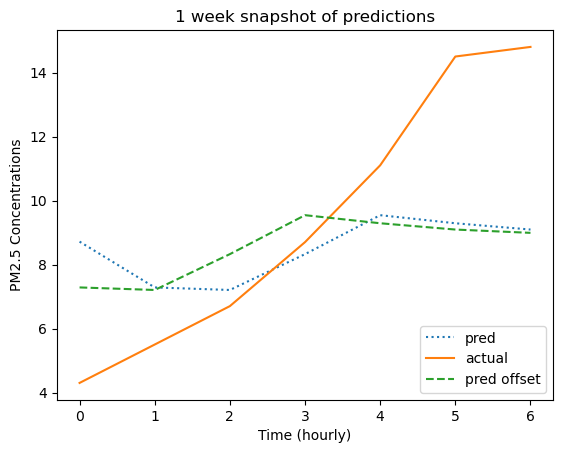

In [16]:
plt.plot(y_pred[:7, 0], linestyle=':', label='pred')
plt.plot(Y_test[:7, 0], label='actual')
plt.plot(y_pred[1:8, 0], linestyle='--', label='pred offset')
plt.xlabel("Time (hourly)")
plt.ylabel("PM2.5 Concentrations")
plt.title("1 week snapshot of predictions")
plt.legend(loc="lower right")

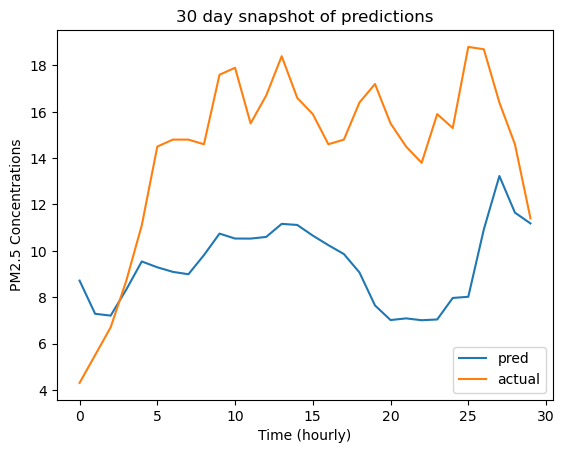

In [17]:
plt.plot(y_pred[:30, 0], label='pred')
plt.plot(Y_test[:30, 0], label='actual')
plt.xlabel("Time (hourly)")
plt.ylabel("PM2.5 Concentrations")
plt.title("30 day snapshot of predictions")
plt.legend(loc="lower right")

In [18]:
WEEK = 7
best_week = float('inf')
worst_week = float('-inf')
best_idx, worst_idx = 0, 0

worst_week_cleaned = float('-inf')
worst_idx_cleaned = 0
for i in range(len(y_pred) - WEEK):
    err = nrmse(y_pred[i:i+WEEK, 0], Y_test[i:i+WEEK, 0])
    if err < best_week:
        best_week = err
        best_idx = i
    if err > worst_week:
        worst_week = err
        worst_idx = i

for i in range(len(cleaned_pred) - WEEK):
    cleaned_err = nrmse(cleaned_pred[i:i+WEEK], cleaned_test[i:i+WEEK])
    if cleaned_err > worst_week_cleaned:
        worst_week_cleaned = cleaned_err
        worst_idx_cleaned = i

print(len(y_pred), len(cleaned_pred))

110 110


In [34]:
dates = pd.date_range(START_DATE, END_DATE, freq='D')[:-frames_per_sample]
y_test_start_idx = len(X_train) + len(X_valid)
y_valid_start_idx = len(X_train)
print(y_valid_start_idx, y_test_start_idx)

508 617


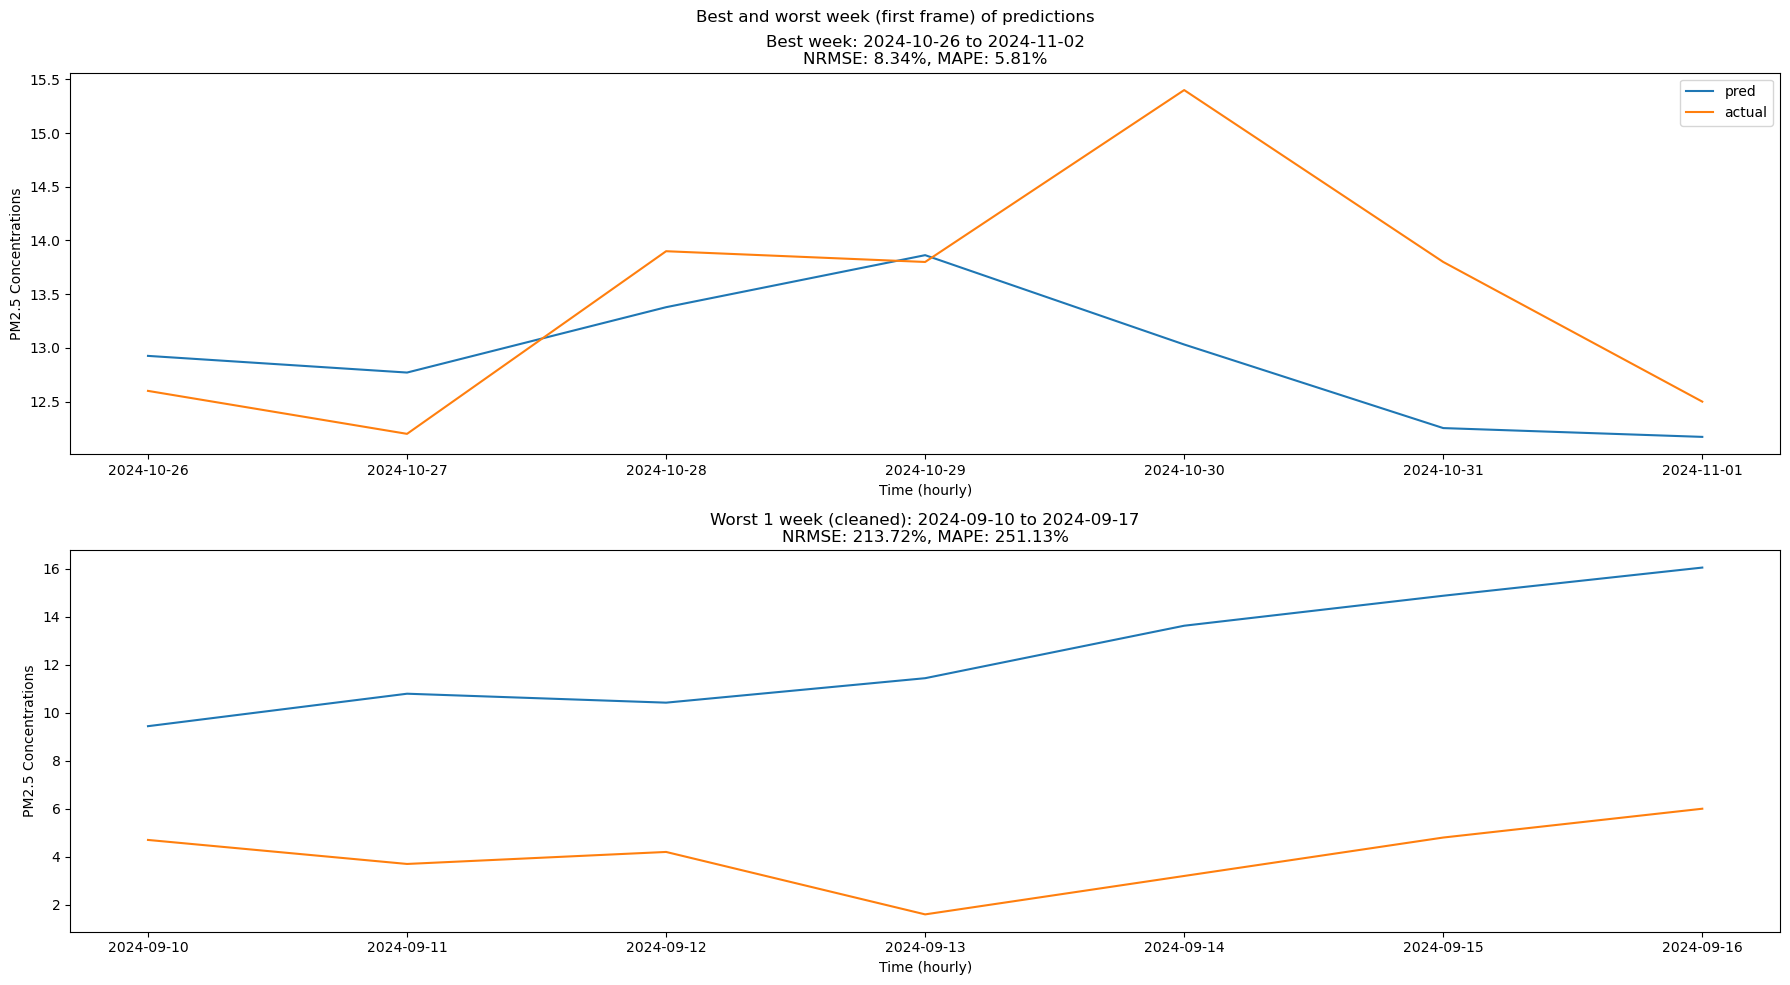

In [20]:
fig, axes = plt.subplots(2, 1, figsize=(18, 10))
fig.suptitle('Best and worst week (first frame) of predictions')

# best week
axes[0].plot(
    dates[y_test_start_idx + best_idx : y_test_start_idx + best_idx + WEEK],
    y_pred[best_idx:best_idx+WEEK, 0],
    label='pred'
)
axes[0].plot(
    dates[y_test_start_idx + best_idx : y_test_start_idx + best_idx + WEEK],
    Y_test[best_idx:best_idx+WEEK, 0],
    label='actual'
)
axes[0].set_xlabel("Time (hourly)")
axes[0].set_ylabel("PM2.5 Concentrations")
axes[0].set_title(
    f"Best week: {dates[y_test_start_idx + best_idx].strftime('%Y-%m-%d')} to "
    f"{dates[y_test_start_idx + best_idx + WEEK].strftime('%Y-%m-%d')}\n"
    f"NRMSE: {best_week:.2f}%, "
    f"MAPE: {mape(
        np.squeeze(Y_test[best_idx : best_idx + WEEK]), 
        np.squeeze(y_pred[best_idx : best_idx + WEEK])
    )*100:.2f}%"
)
axes[0].legend(loc="upper right")

# worst week (cleaned)
axes[1].plot(
    dates[y_test_start_idx + worst_idx_cleaned : y_test_start_idx + worst_idx_cleaned + WEEK],
    cleaned_pred[worst_idx_cleaned:worst_idx_cleaned+WEEK, 0], 
    label='pred'
)
axes[1].plot(
    dates[y_test_start_idx + worst_idx_cleaned : y_test_start_idx + worst_idx_cleaned + WEEK],
    cleaned_test[worst_idx_cleaned:worst_idx_cleaned+WEEK, 0],
    label='actual'
)
axes[1].set_xlabel("Time (hourly)")
axes[1].set_ylabel("PM2.5 Concentrations")
axes[1].set_title(
    f"Worst 1 week (cleaned): {dates[y_test_start_idx + worst_idx_cleaned].strftime('%Y-%m-%d')} to "
    f"{dates[y_test_start_idx + worst_idx_cleaned + WEEK].strftime('%Y-%m-%d')}\n"
    f"NRMSE: {worst_week_cleaned:.2f}%, "
    f"MAPE: {mape(
        np.squeeze(Y_test[worst_idx_cleaned : worst_idx_cleaned + WEEK]), 
        np.squeeze(y_pred[worst_idx_cleaned : worst_idx_cleaned + WEEK])
    )*100:.2f}%"
)
axes[0].legend(loc="upper right")

plt.tight_layout()
plt.show()

## Rolling avg plots

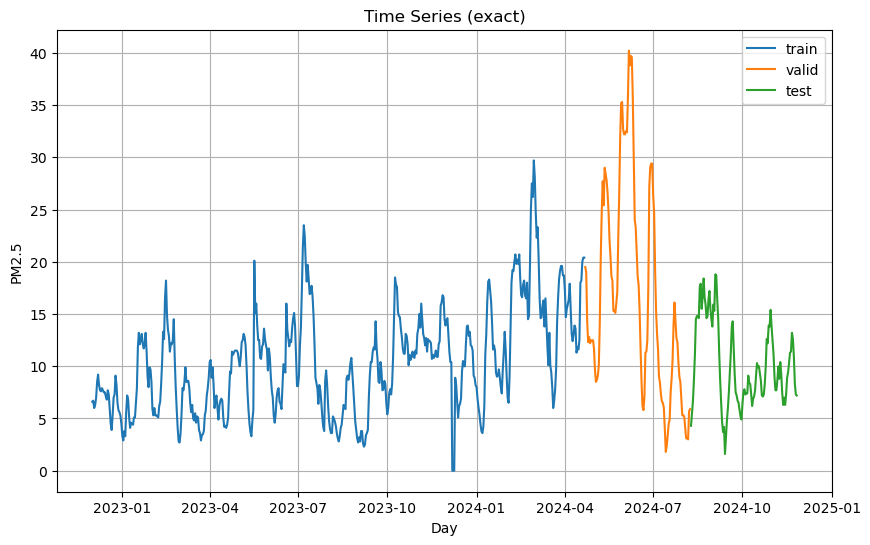

In [39]:
# underlying data distribution
plt.figure(figsize=(10, 6))
#plt.plot(dates, np.squeeze(np.concatenate([Y_train, Y_valid, Y_test])))
plt.plot(dates[:y_valid_start_idx], np.squeeze(Y_train), label=f'train')
plt.plot(dates[y_valid_start_idx : y_test_start_idx], np.squeeze(Y_valid), label=f'valid')
plt.plot(dates[y_test_start_idx:], np.squeeze(Y_test), label=f'test')
#plt.plot(dates, series_test, label=f'actual')
plt.title('Time Series (exact)')
plt.xlabel('Day')
plt.ylabel('PM2.5')
plt.legend()
plt.grid(True)
plt.show()

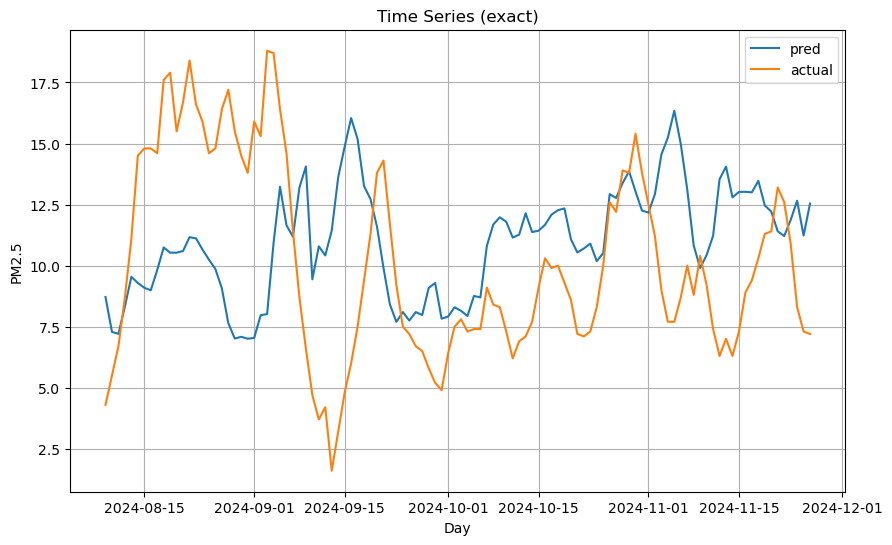

In [21]:
series_pred = pd.Series(np.squeeze(y_pred[:, 0]))
series_test = pd.Series(np.squeeze(Y_test[:, 0]))

plt.figure(figsize=(10, 6))
plt.plot(dates[y_test_start_idx:], series_pred, label=f'pred')
plt.plot(dates[y_test_start_idx:], series_test, label=f'actual')
plt.title('Time Series (exact)')
plt.xlabel('Day')
plt.ylabel('PM2.5')
plt.legend()
plt.grid(True)
plt.show()

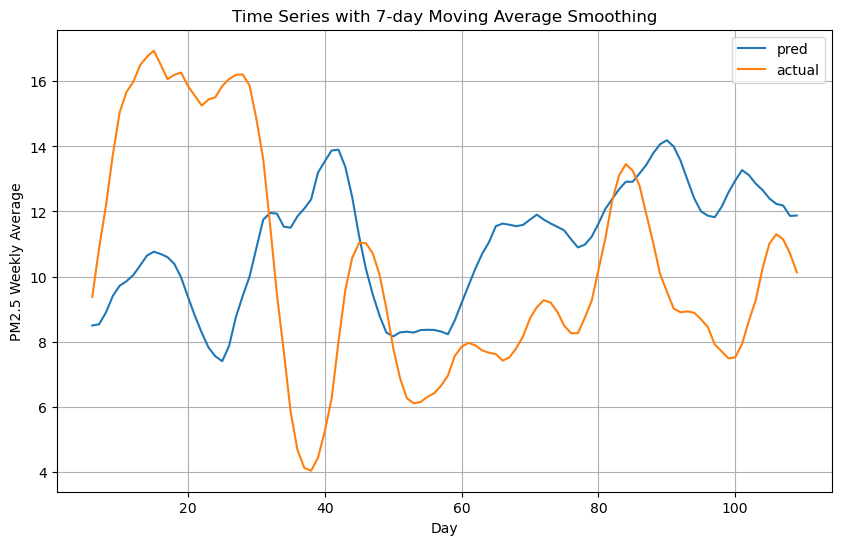

In [22]:
import pandas as pd

window_size = 7 # weekly average
smoothed_pred = series_pred.rolling(window=window_size).mean()
smoothed_test = series_test.rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(smoothed_pred, label=f'pred')
plt.plot(smoothed_test, label=f'actual')
plt.title('Time Series with 7-day Moving Average Smoothing')
plt.xlabel('Day')
plt.ylabel('PM2.5 Weekly Average')
plt.legend()
plt.grid(True)
plt.show()

## Error plots (first frame)

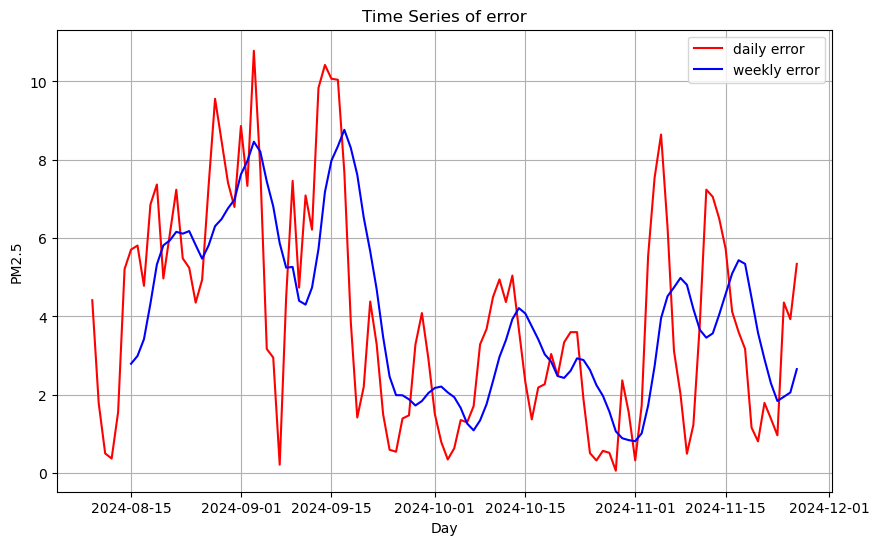

In [23]:
series = pd.Series(np.squeeze(np.abs(y_pred[:, 0] - Y_test[:, 0])))
window_size = WEEK # weekly average
smoothed_series = series.rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(dates[y_test_start_idx:], series, label=f'daily error', color='red')
plt.plot(dates[y_test_start_idx:], smoothed_series, label=f'weekly error', color='blue')
plt.title('Time Series of error')
plt.xlabel('Day')
plt.ylabel('PM2.5')
plt.legend()
plt.grid(True)
plt.show()